
Reading Intan Technologies RHD2000 Data File, Version 3.0

n signal groups 7
Found 64 amplifier channels.
Found 6 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 0.883 seconds of data.  Amplifiers were sampled at 20.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
100% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds


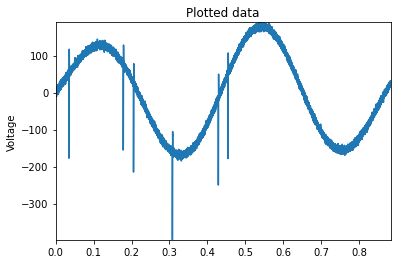

In [1]:
%run importintanutilities.py

tic = time.time()
filename = 'sampledata.rhd'
fid = open(filename, 'rb')
filesize = os.path.getsize(filename)

header = read_header(fid)

print('Found {} amplifier channel{}.'.format(header['num_amplifier_channels'], plural(header['num_amplifier_channels'])))
print('Found {} auxiliary input channel{}.'.format(header['num_aux_input_channels'], plural(header['num_aux_input_channels'])))
print('Found {} supply voltage channel{}.'.format(header['num_supply_voltage_channels'], plural(header['num_supply_voltage_channels'])))
print('Found {} board ADC channel{}.'.format(header['num_board_adc_channels'], plural(header['num_board_adc_channels'])))
print('Found {} board digital input channel{}.'.format(header['num_board_dig_in_channels'], plural(header['num_board_dig_in_channels'])))
print('Found {} board digital output channel{}.'.format(header['num_board_dig_out_channels'], plural(header['num_board_dig_out_channels'])))
print('Found {} temperature sensors channel{}.'.format(header['num_temp_sensor_channels'], plural(header['num_temp_sensor_channels'])))
print('')

# Determine how many samples the data file contains.
bytes_per_block = get_bytes_per_data_block(header)

# How many data blocks remain in this file?
data_present = False
bytes_remaining = filesize - fid.tell()
if bytes_remaining > 0:
    data_present = True

if bytes_remaining % bytes_per_block != 0:
    raise Exception('Something is wrong with file size : should have a whole number of data blocks')

num_data_blocks = int(bytes_remaining / bytes_per_block)

num_amplifier_samples = header['num_samples_per_data_block'] * num_data_blocks
num_aux_input_samples = int((header['num_samples_per_data_block'] / 4) * num_data_blocks)
num_supply_voltage_samples = 1 * num_data_blocks
num_board_adc_samples = header['num_samples_per_data_block'] * num_data_blocks
num_board_dig_in_samples = header['num_samples_per_data_block'] * num_data_blocks
num_board_dig_out_samples = header['num_samples_per_data_block'] * num_data_blocks

record_time = num_amplifier_samples / header['sample_rate']

if data_present:
    print('File contains {:0.3f} seconds of data.  Amplifiers were sampled at {:0.2f} kS/s.'.format(record_time, header['sample_rate'] / 1000))
else:
    print('Header file contains no data.  Amplifiers were sampled at {:0.2f} kS/s.'.format(header['sample_rate'] / 1000))

if data_present:
    # Pre-allocate memory for data.
    print('')
    print('Allocating memory for data...')

    data = {}
    if (header['version']['major'] == 1 and header['version']['minor'] >= 2) or (header['version']['major'] > 1):
        data['t_amplifier'] = np.zeros(num_amplifier_samples, dtype=np.int)
    else:
        data['t_amplifier'] = np.zeros(num_amplifier_samples, dtype=np.uint)

    data['amplifier_data'] = np.zeros([header['num_amplifier_channels'], num_amplifier_samples], dtype=np.uint)
    data['aux_input_data'] = np.zeros([header['num_aux_input_channels'], num_aux_input_samples], dtype=np.uint)
    data['supply_voltage_data'] = np.zeros([header['num_supply_voltage_channels'], num_supply_voltage_samples], dtype=np.uint)
    data['temp_sensor_data'] = np.zeros([header['num_temp_sensor_channels'], num_supply_voltage_samples], dtype=np.uint)
    data['board_adc_data'] = np.zeros([header['num_board_adc_channels'], num_board_adc_samples], dtype=np.uint)

    # by default, this script interprets digital events (digital inputs and outputs) as booleans
    # if unsigned int values are preferred(0 for False, 1 for True), replace the 'dtype=np.bool' argument with 'dtype=np.uint' as shown
    # the commented line below illustrates this for digital input data; the same can be done for digital out

    #data['board_dig_in_data'] = np.zeros([header['num_board_dig_in_channels'], num_board_dig_in_samples], dtype=np.uint)
    data['board_dig_in_data'] = np.zeros([header['num_board_dig_in_channels'], num_board_dig_in_samples], dtype=np.bool)
    data['board_dig_in_raw'] = np.zeros(num_board_dig_in_samples, dtype=np.uint)

    data['board_dig_out_data'] = np.zeros([header['num_board_dig_out_channels'], num_board_dig_out_samples], dtype=np.bool)
    data['board_dig_out_raw'] = np.zeros(num_board_dig_out_samples, dtype=np.uint)

    # Read sampled data from file.
    print('Reading data from file...')

    # Initialize indices used in looping
    indices = {}
    indices['amplifier'] = 0
    indices['aux_input'] = 0
    indices['supply_voltage'] = 0
    indices['board_adc'] = 0
    indices['board_dig_in'] = 0
    indices['board_dig_out'] = 0

    print_increment = 10
    percent_done = print_increment
    for i in range(num_data_blocks):
        read_one_data_block(data, header, indices, fid)

        # Increment indices
        indices['amplifier'] += header['num_samples_per_data_block']
        indices['aux_input'] += int(header['num_samples_per_data_block'] / 4)
        indices['supply_voltage'] += 1
        indices['board_adc'] += header['num_samples_per_data_block']
        indices['board_dig_in'] += header['num_samples_per_data_block']
        indices['board_dig_out'] += header['num_samples_per_data_block']            

        fraction_done = 100 * (1.0 * i / num_data_blocks)
        if fraction_done >= percent_done:
            print('{}% done...'.format(percent_done))
            percent_done = percent_done + print_increment
            
    print('100% done...')

    # Make sure we have read exactly the right amount of data.
    bytes_remaining = filesize - fid.tell()
    if bytes_remaining != 0: raise Exception('Error: End of file not reached.')


fid.close()

if (data_present):
    print('Parsing data...')

    # Extract digital input channels to separate variables.
    for i in range(header['num_board_dig_in_channels']):
        data['board_dig_in_data'][i, :] = np.not_equal(np.bitwise_and(data['board_dig_in_raw'], (1 << header['board_dig_in_channels'][i]['native_order'])), 0)

    # Extract digital output channels to separate variables.
    for i in range(header['num_board_dig_out_channels']):
        data['board_dig_out_data'][i, :] = np.not_equal(np.bitwise_and(data['board_dig_out_raw'], (1 << header['board_dig_out_channels'][i]['native_order'])), 0)

    # Scale voltage levels appropriately.
    data['amplifier_data'] = np.multiply(0.195, (data['amplifier_data'].astype(np.int32) - 32768))      # units = microvolts
    data['aux_input_data'] = np.multiply(37.4e-6, data['aux_input_data'])               # units = volts
    data['supply_voltage_data'] = np.multiply(74.8e-6, data['supply_voltage_data'])     # units = volts
    if header['eval_board_mode'] == 1:
        data['board_adc_data'] = np.multiply(152.59e-6, (data['board_adc_data'].astype(np.int32) - 32768)) # units = volts
    elif header['eval_board_mode'] == 13:
        data['board_adc_data'] = np.multiply(312.5e-6, (data['board_adc_data'].astype(np.int32) - 32768)) # units = volts
    else:
        data['board_adc_data'] = np.multiply(50.354e-6, data['board_adc_data'])           # units = volts
    data['temp_sensor_data'] = np.multiply(0.01, data['temp_sensor_data'])               # units = deg C

    # Check for gaps in timestamps.
    num_gaps = np.sum(np.not_equal(data['t_amplifier'][1:]-data['t_amplifier'][:-1], 1))
    if num_gaps == 0:
        print('No missing timestamps in data.')
    else:
        print('Warning: {0} gaps in timestamp data found.  Time scale will not be uniform!'.format(num_gaps))

    # Scale time steps (units = seconds).
    data['t_amplifier'] = data['t_amplifier'] / header['sample_rate']
    data['t_aux_input'] = data['t_amplifier'][range(0, len(data['t_amplifier']), 4)]
    data['t_supply_voltage'] = data['t_amplifier'][range(0, len(data['t_amplifier']), header['num_samples_per_data_block'])]
    data['t_board_adc'] = data['t_amplifier']
    data['t_dig'] = data['t_amplifier']
    data['t_temp_sensor'] = data['t_supply_voltage']

    # If the software notch filter was selected during the recording, apply the
    # same notch filter to amplifier data here.
    if header['notch_filter_frequency'] > 0 and header['version']['major'] < 3:
        print('Applying notch filter...')

        print_increment = 10
        percent_done = print_increment
        for i in range(header['num_amplifier_channels']):
            data['amplifier_data'][i,:] = notch_filter(data['amplifier_data'][i,:], header['sample_rate'], header['notch_filter_frequency'], 10)

            fraction_done = 100 * (i / header['num_amplifier_channels'])
            if fraction_done >= percent_done:
                print('{}% done...'.format(percent_done))
                percent_done += print_increment
else:
    data = [];

# Move variables to result struct.
result = data_to_result(header, data, data_present)

print('Done!  Elapsed time: {0:0.1f} seconds'.format(time.time() - tic))

fig, ax = plt.subplots()
ax.set_title('Plotted data')
ax.set_ylabel('Voltage')
ax.plot(data['t_amplifier'], data['amplifier_data'][1,:])
ax.margins(x=0, y=0)